In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from simplex.algorithm import NelderMeadSimplex
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [13]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', titlesize=28) #24
rc('axes', labelsize=28) #24
rc("axes", linewidth=2) #2)
rc('axes', labelpad=10) #24)
rc('xtick', labelsize=22)
rc('ytick', labelsize=22)
rc('legend', fontsize=22)
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=5) #8)
rc('ytick.major', pad=5) #8)
rc('xtick.major', size=22) #8)
rc('ytick.major', size=22) #8)
rc('xtick.minor', size=22) #8)
rc('ytick.minor', size=22) #8)
rc('figure', titlesize=30) #24)

def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD=10.
    ax.xaxis.OFFSETTEXTPAD=10.

In [14]:
def objective(xs):
    x1, x2 = xs[0], xs[1]
    return 0.2*(1 - x1)**2 + 0.5 * (x2 - x1**2)**2 + 0.5*np.sin(3*x1) * np.cos(3*x2) - np.sin(x1*x2)

In [15]:
simplices1 = []
simplices2 = []

def callback_simplex1(args):
    simplices1.append(args[0])

def callback_simplex2(args):
    simplices2.append(args[0])

In [16]:
simplex1 = np.array([[-0.5, -0.2], [-0.1, 0.2], [-1, 0.5]])
nm1 = NelderMeadSimplex(objective, simplex1, epsilon=1e-6, max_iter=20, callback=callback_simplex1)
solution_nm1 = nm1.solve()
print(f"Solution from Nelder-Mead Simplex (init 1): {solution_nm1}")
print(f"Objective value: {objective(solution_nm1)}")

Solution from Nelder-Mead Simplex (init 1): [-0.37531158 -0.0470331 ]
Objective value: -0.06855283194391582


In [17]:
simplex2 = np.array([[1.2, -0.3], [1.6, 0.1], [0.9, 0.4]])
nm2 = NelderMeadSimplex(objective, simplex2, epsilon=1e-6, max_iter=20, callback=callback_simplex2)
solution_nm2 = nm2.solve()
print(f"Solution from Nelder-Mead Simplex (init 2): {solution_nm2}")
print(f"Objective value: {objective(solution_nm2)}")

Solution from Nelder-Mead Simplex (init 2): [0.87877502 1.11664155]
Objective value: -1.005752093350937


In [18]:
combined_simplices = simplices1 + simplices2

In [19]:
x_nm_min = min(s[i][0] for s in combined_simplices for i in {0, 1, 2})
x_nm_max = max(s[i][0] for s in combined_simplices for i in {0, 1, 2})
y_nm_min = min(s[i][1] for s in combined_simplices for i in {0, 1, 2})
y_nm_max = max(s[i][1] for s in combined_simplices for i in {0, 1, 2})

In [20]:
bounds = [(-100, 100), (-100, 100)]
from scipy.optimize import differential_evolution
try:
    from scipy.optimize._differentialevolution import DifferentialEvolutionSolver
    use_internal_solver = True
except Exception:
    DifferentialEvolutionSolver = None
    use_internal_solver = False

maxiter_de = 20
best_solutions_de = []
populations_per_gen = []

if use_internal_solver:
    solver = DifferentialEvolutionSolver(
        objective, bounds,
        popsize=15, strategy='best1bin', mutation=(0.5, 1), recombination=0.7,
        seed=1,
        init='latinhypercube'
    )

    if hasattr(solver, "init_population_random"):
        solver.init_population_random()
    elif hasattr(solver, "init_population"):
        solver.init_population()
    else:
        pass

    for gen in range(maxiter_de + 1):
        populations_per_gen.append(solver.population.copy())  # shape (popsize * nvar, nvar)
        best_idx = np.argmin(solver.population_energies)
        best_solutions_de.append(solver.population[best_idx].copy())

        try:
            next(solver)
        except StopIteration:
            break

    result_de = type("Result", (), {})()
    result_de.x = np.array(best_solutions_de[-1])
    result_de.fun = objective(result_de.x)

else:
    best_solutions_de = []
    def callback_de(xk, convergence=None):
        best_solutions_de.append(np.copy(xk))
    result_de = differential_evolution(objective, bounds, seed=1, callback=callback_de, maxiter=maxiter_de)
    populations_per_gen = None

print(f"Solution from Differential Evolution: {result_de.x}")
print(f"Objective value: {result_de.fun}")

Solution from Differential Evolution: [0.50969157 0.5206086 ]
Objective value: -0.17567074037941588


In [21]:
if populations_per_gen is not None and len(populations_per_gen) > 0:
    allpop = np.vstack(populations_per_gen)
    x_de_min = allpop[:, 0].min()
    x_de_max = allpop[:, 0].max()
    y_de_min = allpop[:, 1].min()
    y_de_max = allpop[:, 1].max()
else:
    best_solutions_de = np.array(best_solutions_de)
    x_de_min = best_solutions_de[:, 0].min()
    x_de_max = best_solutions_de[:, 0].max()
    y_de_min = best_solutions_de[:, 1].min()
    y_de_max = best_solutions_de[:, 1].max()

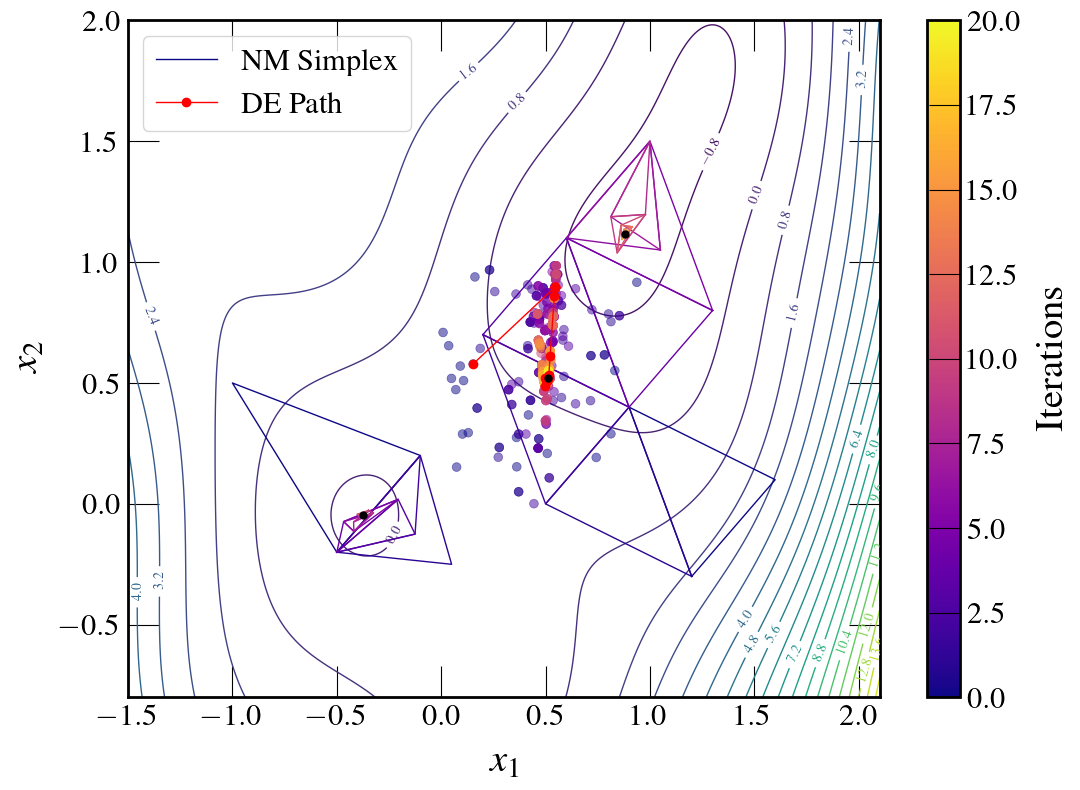

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))

x_min = min(x_nm_min, x_de_min)
x_max = max(x_nm_max, x_de_max)
y_min = min(y_nm_min, y_de_min)
y_max = max(y_nm_max, y_de_max)

x = np.linspace(x_min - 0.5, x_max + 0.5, 1000)
y = np.linspace(y_min - 0.5, y_max + 0.5, 1000)
X, Y = np.meshgrid(x, y)
Z = objective((X, Y))

cs = ax.contour(X, Y, Z, 20)
ax.clabel(cs, inline=1, fontsize=10)

norm_all = Normalize(vmin=0, vmax=maxiter_de)
sm_all = ScalarMappable(norm=norm_all, cmap='plasma')
sm_all.set_array([])

for j, simplex in enumerate(simplices1):
    color = plt.cm.plasma(norm_all(j))
    if j == 0:
        ax.plot(*zip(simplex[0], simplex[1], simplex[2], simplex[0]),
                c=color, label='NM Simplex')
    else:
        ax.plot(*zip(simplex[0], simplex[1], simplex[2], simplex[0]),
                c=color)

for j, simplex in enumerate(simplices2):
    color = plt.cm.plasma(norm_all(j))
    if j == 0:
        ax.plot(*zip(simplex[0], simplex[1], simplex[2], simplex[0]),
                c=color)
    else:
        ax.plot(*zip(simplex[0], simplex[1], simplex[2], simplex[0]),
                c=color)

if populations_per_gen is not None and len(populations_per_gen) > 0:
    all_pops = np.vstack(populations_per_gen)
    gens = np.concatenate([np.full(len(p), i) for i, p in enumerate(populations_per_gen)])
else:
    all_pops = np.empty((0, 2))
    gens = np.array([])

if all_pops.size > 0:
    sc = ax.scatter(all_pops[:, 0], all_pops[:, 1], c=gens, cmap='plasma', norm=norm_all,
                    s=40, marker='o', linewidth=0.5, zorder=2, alpha=0.5)
else:
    sc = None

best_solutions_de = np.array(best_solutions_de)
ax.plot(best_solutions_de[:, 0], best_solutions_de[:, 1], 'o-', c='red', label='DE Path')

ax.scatter(solution_nm1[0], solution_nm1[1], c='k', s=20, marker='o', linewidths=1.5, zorder=10)
ax.scatter(solution_nm2[0], solution_nm2[1], c='k', s=20, marker='o', linewidths=1.5, zorder=10)
ax.scatter(result_de.x[0], result_de.x[1], c='k', s=20, marker='o', linewidths=1.5, zorder=10)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

cbar = fig.colorbar(sm_all, ax=ax)
cbar.set_label('Iterations')

plt.tight_layout()
ax.legend()
plt.show()